In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import math
import sys
import csv
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.functional import normalize
import torch.optim as optim

#from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression as Log_Reg
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from sklearn.feature_selection import RFE
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import RFECV
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import StratifiedKFold

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
import plotly.figure_factory as ff
import plotly.io as pio


In [ ]:
#Data upload
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!cp /content/gdrive/MyDrive/Darknet.CSV /content/

In [ ]:
df = pd.read_csv('/content/Darknet.CSV')
df.tail()

,Flow ID,Src IP,Src Port,Dst IP,Dst Port,Protocol,Timestamp,Flow Duration,Total Fwd Packet,Total Bwd packets,...,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label,Label.1
141525,10.8.8.246-224.0.0.252-55219-5355-17,10.8.8.246,55219,224.0.0.252,5355,17,22/05/2015 01:55:03 PM,411806,2,0,...,0,0,0,0,0.000000e+00,0.00,0.000000e+00,0.000000e+00,VPN,VOIP
141526,10.8.8.246-224.0.0.252-64207-5355-17,10.8.8.246,64207,224.0.0.252,5355,17,22/05/2015 02:09:05 PM,411574,2,0,...,0,0,0,0,0.000000e+00,0.00,0.000000e+00,0.000000e+00,VPN,VOIP
141527,10.8.8.246-224.0.0.252-61115-5355-17,10.8.8.246,61115,224.0.0.252,5355,17,22/05/2015 02:19:31 PM,422299,2,0,...,0,0,0,0,0.000000e+00,0.00,0.000000e+00,0.000000e+00,VPN,VOIP
141528,10.8.8.246-224.0.0.252-64790-5355-17,10.8.8.246,64790,224.0.0.252,5355,17,22/05/2015 02:29:55 PM,411855,2,0,...,0,0,0,0,0.000000e+00,0.00,0.000000e+00,0.000000e+00,VPN,VOIP
141529,80.239.235.110-10.8.8.246-11666-60245-17,80.239.235.110,11666,10.8.8.246,60245,17,22/05/2015 02:31:23 PM,119990044,5995,6000,...,0,0,0,0,1.432320e+15,34636892.93,1.432320e+15,1.432320e+15,VPN,VOIP


In [ ]:
print(len(df))
print(len(df.columns))

141530
85


# Preprocessing

## Drop

In [ ]:
# Data cleaning: drop irrelevant features or outliners
df=df.dropna() #drop rows with nan numbers
df.replace([np.inf, -np.inf], 0, inplace=True) # replace inf with zero
df.columns[(df == 0).all()] # Check if there are any columns whose elements are all zeros
df=df.loc[:, (df != 0).any(axis=0)]
df=df.drop(['Flow ID', 'Timestamp'], axis=1)
df.tail()
#17 features are dropped

,Src IP,Src Port,Dst IP,Dst Port,Protocol,Flow Duration,Total Fwd Packet,Total Bwd packets,Total Length of Fwd Packet,Total Length of Bwd Packet,...,FWD Init Win Bytes,Bwd Init Win Bytes,Fwd Act Data Pkts,Fwd Seg Size Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label,Label.1
141525,10.8.8.246,55219,224.0.0.252,5355,17,411806,2,0,44,0,...,0,0,1,8,0.000000e+00,0.00,0.000000e+00,0.000000e+00,VPN,VOIP
141526,10.8.8.246,64207,224.0.0.252,5355,17,411574,2,0,44,0,...,0,0,1,8,0.000000e+00,0.00,0.000000e+00,0.000000e+00,VPN,VOIP
141527,10.8.8.246,61115,224.0.0.252,5355,17,422299,2,0,44,0,...,0,0,1,8,0.000000e+00,0.00,0.000000e+00,0.000000e+00,VPN,VOIP
141528,10.8.8.246,64790,224.0.0.252,5355,17,411855,2,0,44,0,...,0,0,1,8,0.000000e+00,0.00,0.000000e+00,0.000000e+00,VPN,VOIP
141529,80.239.235.110,11666,10.8.8.246,60245,17,119990044,5995,6000,497585,498000,...,0,0,5994,8,1.432320e+15,34636892.93,1.432320e+15,1.432320e+15,VPN,VOIP


In [ ]:
df.to_csv('data.csv')

In [ ]:
cols = df.columns.tolist()
cols = cols[-1:] + cols[:-1]
df=df[cols]
df.head()

,Label.1,Src IP,Src Port,Dst IP,Dst Port,Protocol,Flow Duration,Total Fwd Packet,Total Bwd packets,Total Length of Fwd Packet,...,Subflow Bwd Bytes,FWD Init Win Bytes,Bwd Init Win Bytes,Fwd Act Data Pkts,Fwd Seg Size Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,AUDIO-STREAMING,10.152.152.11,57158,216.58.220.99,443,6,229,1,1,0,...,0,1892,1047,0,20,0.000000e+00,0.000,0.000000e+00,0.000000e+00,Non-Tor
1,AUDIO-STREAMING,10.152.152.11,57159,216.58.220.99,443,6,407,1,1,0,...,0,1987,1047,0,20,0.000000e+00,0.000,0.000000e+00,0.000000e+00,Non-Tor
2,AUDIO-STREAMING,10.152.152.11,57160,216.58.220.99,443,6,431,1,1,0,...,0,2049,1047,0,20,0.000000e+00,0.000,0.000000e+00,0.000000e+00,Non-Tor
3,AUDIO-STREAMING,10.152.152.11,49134,74.125.136.120,443,6,359,1,1,0,...,0,2008,1047,0,20,0.000000e+00,0.000,0.000000e+00,0.000000e+00,Non-Tor
4,AUDIO-STREAMING,10.152.152.11,34697,173.194.65.127,19305,6,10778451,591,400,64530,...,6,1382,2320,581,20,1.437760e+15,3117718.131,1.437760e+15,1.437760e+15,Non-Tor


## extract regular traffic

In [ ]:
regular=df.loc[df['Label'] == 'NonVPN']
len(regular)
#23861 non vpn samples

23861

In [ ]:
regular.to_csv('nonvpn.csv')

In [ ]:
Total = regular['Total Fwd Packet'].sum()

In [ ]:
print(Total)

5639844


In [ ]:
#regular.to_csv('data.csv') //non-vpn

In [ ]:
regular2=df.loc[df['Label'] == 'Non-Tor']
len(regular2)
#93311 non tor samples

93311

In [ ]:
Total = regular2['Total Fwd Packet'].sum()
print(Total)

5228840


In [ ]:
regular2.to_csv('nontor.csv')

In [ ]:
regular = regular.append(regular2, ignore_index = True)

In [ ]:
len(regular)

117172

## VPN and Tor Information

In [ ]:
myVPN=df.loc[df['Label'] == 'VPN']
len(myVPN)
#22919 non vpn samples

22919

In [ ]:
myVPN.to_csv('vpn.csv')

In [ ]:
myTor=df.loc[df['Label'] == 'Tor']
#myTor.head()
len(myTor)
#1392 non vpn samples

1392

In [ ]:
Total = myTor['Total Fwd Packet'].sum()
print(Total)

8675145


In [ ]:
darkTraffic = myVPN.append(myTor, ignore_index = True)

<ipython-input-32-95280e217421>:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  darkTraffic = myVPN.append(myTor, ignore_index = True)


In [ ]:
len(darkTraffic)

24311

In [ ]:
newDarknet = darkTraffic.filter(['Flow IAT Min', 'Idle Max','Bwd Packet Length Min','Fwd Seg Size Min','Flow IAT Mean',\
                        'Bwd Segment Size Avg','Subflow Bwd Bytes','Flow Packets/s','Bwd Packet Length Mean',\
                        'Idle Mean','Fwd Header Length','Flow IAT Max','Bwd Packets/s','Flow Bytes/s','Fwd Packets/s'], axis=1)
newRegular = regular.filter(['Flow IAT Min', 'Idle Max','Bwd Packet Length Min','Fwd Seg Size Min','Flow IAT Mean',\
                        'Bwd Segment Size Avg','Subflow Bwd Bytes','Flow Packets/s','Bwd Packet Length Mean',\
                        'Idle Mean','Fwd Header Length','Flow IAT Max','Bwd Packets/s','Flow Bytes/s','Fwd Packets/s'], axis=1)

In [ ]:
np_darknet = darkTraffic['Flow IAT Min'].values
np_regular = regular['Flow IAT Min'].values

In [ ]:
np_idlemax = darkTraffic['Idle Max'].values
np_idlemaxreg = regular['Idle Max'].values

In [ ]:
np_regular[2]

413396

In [ ]:
def standardize_preprocessing(np_processed):
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(np_processed)
    return scaled_data

In [ ]:
np_darknet=standardize_preprocessing(newDarknet)

In [ ]:
np_Regular=standardize_preprocessing(newRegular)

In [ ]:
IATMin=np.zeros((20000))
IATMinReg=np.zeros((20000))
for i in range(20000):
    IATMin[i]=np_darknet[i][5]
    IATMinReg[i]=np_Regular[i][5]

In [ ]:
IdleMax=np.zeros((20000))
IdleMaxReg=np.zeros((20000))
for i in range(20000):
    IdleMax[i]=np_idlemax[i]
    IdleMaxReg[i]=np_idlemaxreg[i]

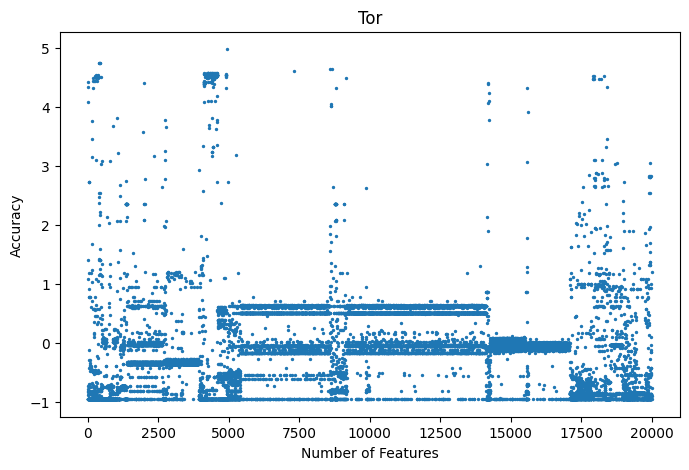

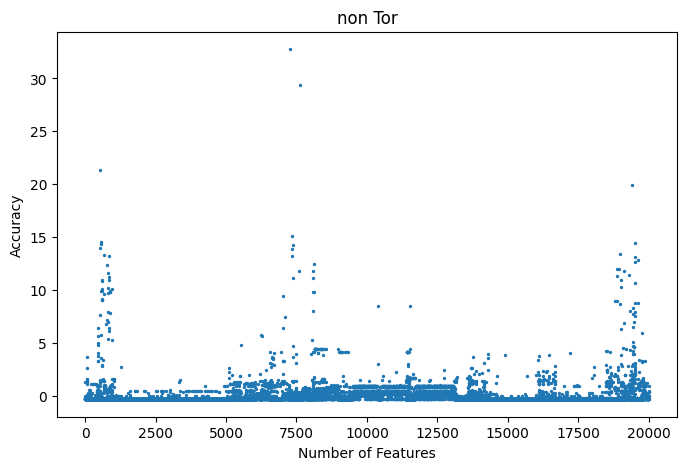

In [ ]:

# Create an array of indices
indices = np.arange(20000)
# Plot the array
fig99=plt.figure(figsize=(8, 5))
plt.scatter(indices, IATMin, s=2)
plt.xlabel('Number of Features')
plt.ylabel('Accuracy')
plt.title('Tor')
#plt.xticks(indices, fontsize=12)
#plt.yticks(fontsize=12)
plt.show()


# Create an array of indices
indices = np.arange(20000)
# Plot the array
fig99=plt.figure(figsize=(8, 5))
plt.scatter(indices, IATMinReg, s=2)
plt.xlabel('Number of Features')
plt.ylabel('Accuracy')
plt.title('non Tor')
#plt.xticks(indices, fontsize=12)
#plt.yticks(fontsize=12)
plt.show()

## Sorting

In [ ]:
myTor=myTor.sort_values(by=['Total Fwd Packet'], ascending=True)#'Total Bwd packets','Flow Duration','Total Length of Fwd Packet']

In [ ]:
myTor.tail()

,Src IP,Src Port,Dst IP,Dst Port,Protocol,Flow Duration,Total Fwd Packet,Total Bwd packets,Total Length of Fwd Packet,Total Length of Bwd Packet,...,FWD Init Win Bytes,Bwd Init Win Bytes,Fwd Act Data Pkts,Fwd Seg Size Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label,Label.1
117735,10.0.2.15,36922,198.52.200.39,443,6,119998007,83996,60612,105501088,3326695,...,65535,65535,83476,20,1.437150e+15,34344083.73,1.437150e+15,1.437150e+15,Tor,File-Transfer
117743,10.0.2.15,36922,198.52.200.39,443,6,119998538,99421,71413,125555103,3994063,...,65535,65535,98837,20,1.437150e+15,34669680.89,1.437150e+15,1.437150e+15,Tor,File-Transfer
117776,10.0.2.15,36922,198.52.200.39,443,6,119578967,104789,76695,130842675,7308047,...,65535,65535,103094,20,1.437150e+15,32253399.69,1.437150e+15,1.437150e+15,Tor,File-Transfer
117744,10.0.2.15,36922,198.52.200.39,443,6,119952629,112274,80558,141400896,4471215,...,65535,65535,111629,20,1.437150e+15,35117551.65,1.437150e+15,1.437150e+15,Tor,File-Transfer
117747,10.0.2.15,36922,198.52.200.39,443,6,119961884,113960,81630,143491751,4534472,...,65535,65535,113325,20,1.437150e+15,34446049.98,1.437150e+15,1.437150e+15,Tor,File-Transfer


In [ ]:
myTor.to_csv('Tor_sort.csv')


In [ ]:
myVPN=myVPN.sort_values(by=['Total Fwd Packet'], ascending=True)#'Total Bwd packets','Flow Duration','Total Length of Fwd Packet']

In [ ]:
myVPN.tail()

,Src IP,Src Port,Dst IP,Dst Port,Protocol,Flow Duration,Total Fwd Packet,Total Bwd packets,Total Length of Fwd Packet,Total Length of Bwd Packet,...,FWD Init Win Bytes,Bwd Init Win Bytes,Fwd Act Data Pkts,Fwd Seg Size Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label,Label.1
140240,10.8.8.138,43533,185.2.220.137,80,6,118606790,21114,40845,28076,53394404,...,13270,2048,41,32,1.432490e+15,32752575.90,1.432490e+15,1.432490e+15,VPN,Video-Streaming
140233,10.8.8.138,43533,185.2.220.137,80,6,117720900,21288,41527,30721,54278158,...,2048,2048,44,32,1.432490e+15,34434102.73,1.432490e+15,1.432490e+15,VPN,Video-Streaming
122546,10.8.8.138,43336,75.101.155.12,22,6,119951862,24085,12997,30643843,166330,...,29200,13364,23959,32,1.430000e+15,24608394.66,1.432320e+15,1.432320e+15,VPN,File-Transfer
122634,10.8.8.138,45849,204.236.238.164,1781,6,44402284,31667,15833,41312808,4173,...,29200,5073,31659,32,1.432320e+15,11624553.52,1.432320e+15,1.432320e+15,VPN,File-Transfer
140031,10.8.8.138,43533,185.2.220.137,80,6,117193925,41588,80733,71286,105285555,...,29200,2048,107,32,1.432490e+15,27333997.21,1.432490e+15,1.432490e+15,VPN,Video-Streaming


In [ ]:
myVPN.to_csv('VPN_sort.csv')

# Feature selection

In [ ]:
'''newDarknet = df.filter(['Total Fwd Packet','Fwd Seg Size Min','Bwd Packet Length Min','FWD Init Win Bytes', \
                        'Fwd Act Data Pkts', 'Fwd Packet Length Max', 'Fwd Header Length','Packet Length Min',\
                        'Average Packet Size', 'Fwd Packet Length Mean'],axis=1)'''
#,'FWD Init Win Bytes','FIN Flag Count','Subflow Bwd Bytes',\
                        #'Total Length of Bwd Packet','Flow Packets/s','Fwd Header Length','Bwd Header Length'], axis=1)
newDarknet = df.filter(['Flow IAT Min', 'Idle Max','Bwd Packet Length Min','Fwd Seg Size Min','Flow IAT Mean',\
                        'Bwd Segment Size Avg','Subflow Bwd Bytes','Flow Packets/s','Bwd Packet Length Mean',\
                        'Idle Mean','Fwd Header Length','Flow IAT Max','Bwd Packets/s','Flow Bytes/s','Fwd Packets/s'], axis=1)


In [ ]:
newDarknet.to_csv('newdarknet.csv')

In [ ]:
#make sure that the feature set only contains numeric values
#pd.to_numeric(df['Total Fwd Packet'], errors='coerce').notnull().all()
#https://stackoverflow.com/questions/54426845/how-to-check-if-a-pandas-dataframe-contains-only-numeric-values-column-wise
newDarknet.apply(lambda s: pd.to_numeric(s, errors='coerce').notnull().all())

Flow IAT Min              True
Idle Max                  True
Bwd Packet Length Min     True
Fwd Seg Size Min          True
Flow IAT Mean             True
Bwd Segment Size Avg      True
Subflow Bwd Bytes         True
Flow Packets/s            True
Bwd Packet Length Mean    True
Idle Mean                 True
Fwd Header Length         True
Flow IAT Max              True
Bwd Packets/s             True
Flow Bytes/s              True
Fwd Packets/s             True
dtype: bool

In [ ]:
target=df.filter(['Label'], axis=1)

In [ ]:
target.loc[0]

Label    Non-Tor
Name: 0, dtype: object

In [ ]:
target=target.replace('Non-Tor',0)
target=target.replace('NonVPN',0)
target=target.replace('VPN',10)
target=target.replace('Tor',10)

In [ ]:
print(target.shape)
print(newDarknet.shape)

(141483, 1)
(141483, 15)


# Classification darknet and regular

## KNN classification Sklearn##

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
import sys
# Create feature and target arrays
X = newDarknet
y = target
# Split into training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=1)
print("Train Size: ", len(y_train))
print("Test Size: ", len(y_test))

Train Size:  113186
Test Size:  28297


In [ ]:
myout=X_test.to_numpy()

In [ ]:
from numpy import savetxt
savetxt('data.csv', myout, delimiter=',')

In [ ]:
k_model = KNeighborsClassifier(n_neighbors=5)
k_model.fit(X_train, y_train)

# test model using test dataset
result=k_model.predict(X_test)
#np.set_printoptions(threshold=sys.maxsize)
#print(irisData)
print(result)

/usr/local/lib/python3.9/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[0 0 0 ... 0 0 0]


In [ ]:
y_test2=y_test.to_numpy()
comp=pd.DataFrame({'True': y_test2.flatten(), 'Predicted': result})
comp

,True,Predicted
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
...,...,...
28292,0,0
28293,10,10
28294,0,0
28295,0,0


In [ ]:
from sklearn.metrics import accuracy_score
from sklearn import metrics
print('Accuracy:', accuracy_score(result,y_test))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, result))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, result)))

Accuracy: 0.939675583984168
Mean Squared Error: 6.032441601583207
Root Mean Squared Error: 2.456102929761537


In [ ]:
print(target)

        Label
0           0
1           0
2           0
3           0
4           0
...       ...
141525     10
141526     10
141527     10
141528     10
141529     10

[141483 rows x 1 columns]


In [ ]:
from sklearn.metrics import confusion_matrix
cmtx = confusion_matrix(y_test, k_model.predict(X_test))
cmtx

array([[22434,   963],
       [  744,  4156]])

In [ ]:
import plotly.figure_factory as ff

fig = ff.create_annotated_heatmap(z=cmtx, showscale=True)
fig.update_layout(font=dict(size=20))
# Add Labels
fig.add_annotation(x=0,y=0, text="Act Reg-Pred Reg", yshift=20, showarrow=False, font=dict(color="black",size=20))
fig.add_annotation(x=1,y=0, text="Act Reg-Pred Tor", yshift=20, showarrow=False, font=dict(color="white",size=20))
fig.add_annotation(x=2,y=0, text="Act Reg-Pred VPN", yshift=20, showarrow=False, font=dict(color="white",size=20))

fig.add_annotation(x=0,y=1, text="Act VPN-Pred Reg", yshift=20, showarrow=False, font=dict(color="white",size=20))
fig.add_annotation(x=1,y=1, text="Act VPN-Pred VPN", yshift=20, showarrow=False, font=dict(color="white",size=20))
fig.add_annotation(x=2,y=1, text="Act VPN-Pred Tor", yshift=20, showarrow=False, font=dict(color="white",size=20))

fig.add_annotation(x=0,y=2, text="Act Tor-Pred Reg", yshift=20, showarrow=False, font=dict(color="white",size=20))
fig.add_annotation(x=1,y=2, text="Act Tor-Pred VPN", yshift=20, showarrow=False, font=dict(color="white",size=20))
fig.add_annotation(x=2,y=2, text="Act Tor-Pred Tor", yshift=20, showarrow=False, font=dict(color="white",size=20))

fig.update_xaxes(title="Predicted")
fig.update_yaxes(title="Actual", autorange="reversed")

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, result))

              precision    recall  f1-score   support

           0       0.95      0.96      0.95     23397
          10       0.80      0.74      0.77      4900

    accuracy                           0.92     28297
   macro avg       0.87      0.85      0.86     28297
weighted avg       0.92      0.92      0.92     28297



## Binary Logistic Regression

In [ ]:
from sklearn import datasets
#iris = datasets.load_iris()

In [ ]:
VPN_binary = target.loc[target["Label"] == 10]
VPN_binary = VPN_binary.iloc[:10000]

tor_binary = target.loc[target["Label"] == 11]

In [ ]:
tar_binary=VPN_binary.append(tor_binary)

In [ ]:
tar_binary
#extract labels and merge

,Label
117219,10
117220,10
117221,10
117222,10
117223,10
...,...
127214,10
127215,10
127216,10
127217,10


In [ ]:
Tor_binary=df.loc[df["Label"]=="Tor"]

In [ ]:
VPN_binary=df.loc[df["Label"]=="VPN"]
VPN_binary = VPN_binary.iloc[:10000]
VPN_binary

,Src IP,Src Port,Dst IP,Dst Port,Protocol,Flow Duration,Total Fwd Packet,Total Bwd packets,Total Length of Fwd Packet,Total Length of Bwd Packet,...,FWD Init Win Bytes,Bwd Init Win Bytes,Fwd Act Data Pkts,Fwd Seg Size Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label,Label.1
118611,74.125.226.38,443,10.8.8.138,51827,6,45,2,0,63,0,...,341,0,0,32,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,VPN,File-Transfer
118612,10.8.8.138,47126,75.101.155.12,22,6,231660,1,1,0,0,...,41632,8415,0,32,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,VPN,File-Transfer
118613,10.8.8.138,51143,74.125.226.56,443,6,10221076,3,1,0,0,...,29200,42540,0,32,7.161610e+14,1.010000e+15,1.432320e+15,1.000137e+07,VPN,File-Transfer
118614,10.8.8.138,51828,74.125.226.38,443,6,59101196,2,4,0,63,...,317,350,0,32,1.432320e+15,3.053902e+07,1.432320e+15,1.430000e+15,VPN,File-Transfer
118615,10.8.8.138,51828,74.125.226.38,443,6,203636,1,1,0,0,...,317,350,0,32,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,VPN,File-Transfer
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128606,10.8.0.10,35014,131.202.244.3,53,17,901,1,1,37,373,...,0,0,0,8,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,VPN,Audio-Streaming
128607,10.8.0.10,53359,131.202.244.5,53,17,666,1,1,37,213,...,0,0,0,8,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,VPN,Audio-Streaming
128608,10.8.0.10,17339,131.202.244.3,53,17,667,1,1,33,345,...,0,0,0,8,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,VPN,Audio-Streaming
128609,173.194.123.26,80,10.8.0.10,47933,6,57,1,1,0,0,...,341,317,0,32,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,VPN,Audio-Streaming


In [ ]:
dark_binary=VPN_binary.append(Tor_binary)
dark_binary.head()
#merge feature sets

,Src IP,Src Port,Dst IP,Dst Port,Protocol,Flow Duration,Total Fwd Packet,Total Bwd packets,Total Length of Fwd Packet,Total Length of Bwd Packet,...,FWD Init Win Bytes,Bwd Init Win Bytes,Fwd Act Data Pkts,Fwd Seg Size Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label,Label.1
118611,74.125.226.38,443,10.8.8.138,51827,6,45,2,0,63,0,...,341,0,0,32,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,VPN,File-Transfer
118612,10.8.8.138,47126,75.101.155.12,22,6,231660,1,1,0,0,...,41632,8415,0,32,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,VPN,File-Transfer
118613,10.8.8.138,51143,74.125.226.56,443,6,10221076,3,1,0,0,...,29200,42540,0,32,7.161610e+14,1.010000e+15,1.432320e+15,1.000137e+07,VPN,File-Transfer
118614,10.8.8.138,51828,74.125.226.38,443,6,59101196,2,4,0,63,...,317,350,0,32,1.432320e+15,3.053902e+07,1.432320e+15,1.430000e+15,VPN,File-Transfer
118615,10.8.8.138,51828,74.125.226.38,443,6,203636,1,1,0,0,...,317,350,0,32,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,VPN,File-Transfer


In [ ]:
dark_binary = dark_binary.filter(['Total Fwd Packet','Idle Max','Fwd Seg Size Min','Bwd Packet Length Min','Protocol','Idle Mean','Fwd Init Win Bytes','FIN Flag Count','Fwd Act Data Pkts'],axis=1)#,'FWD Init Win Bytes','FIN Flag Count','Subflow Bwd Bytes',\
dark_binary

,Total Fwd Packet,Idle Max,Fwd Seg Size Min,Bwd Packet Length Min,Protocol,Idle Mean,FIN Flag Count,Fwd Act Data Pkts
118611,2,0.000000e+00,32,0,6,0.000000e+00,1,0
118612,1,0.000000e+00,32,0,6,0.000000e+00,2,0
118613,3,1.432320e+15,32,0,6,7.161610e+14,1,0
118614,2,1.432320e+15,32,0,6,1.432320e+15,1,0
118615,1,0.000000e+00,32,0,6,0.000000e+00,1,0
...,...,...,...,...,...,...,...,...
118606,1,0.000000e+00,8,238,17,0.000000e+00,0,0
118607,2,0.000000e+00,0,0,0,0.000000e+00,0,0
118608,3,1.427990e+15,32,0,6,1.427980e+15,0,0
118609,3,1.427990e+15,32,0,6,1.427980e+15,0,0


In [ ]:
from sklearn.linear_model import LogisticRegression
X=dark_binary
Y=tar_binary
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state=42)
print("Train Size: ", len(y_train))
print("Test Size: ", len(y_test))

ValueError: ignored

In [ ]:
l_model = LogisticRegression()
l_model.fit(X_train, y_train.values.ravel())
result = l_model.predict(X_test)
result.shape
print(result)

[10 10 10 ... 10 10 10]


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, result))

              precision    recall  f1-score   support

          10       0.88      0.90      0.89      2010
          11       0.08      0.07      0.07       269

    accuracy                           0.80      2279
   macro avg       0.48      0.48      0.48      2279
weighted avg       0.78      0.80      0.79      2279



In [ ]:
from sklearn.metrics import confusion_matrix
cmtx = confusion_matrix(y_test, l_model.predict(X_test))
cmtx

array([[1813,  197],
       [ 251,   18]])

## Multiclass Logistic Regression

In [ ]:
from sklearn.model_selection import train_test_split
X = newDarknet
y = target
# Split into training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state=42)
print("Train Size: ", len(y_train))
print("Test Size: ", len(y_test))

Train Size:  127334
Test Size:  14149


In [ ]:
from sklearn.linear_model import LogisticRegression
l_model = LogisticRegression(multi_class='multinomial', solver='saga')
l_model.fit(X_train, y_train.values.ravel())
result = l_model.predict(X_test)
result.shape
print(result)

[0 0 0 ... 0 0 0]


/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, result))

              precision    recall  f1-score   support

           0       0.83      1.00      0.91     11693
          10       0.71      0.02      0.04      2334
          11       0.22      0.09      0.13       122

    accuracy                           0.83     14149
   macro avg       0.59      0.37      0.36     14149
weighted avg       0.81      0.83      0.76     14149



In [ ]:
from sklearn.metrics import confusion_matrix
cmtx = confusion_matrix(y_test, l_model.predict(X_test))
cmtx

array([[11659,    20,    14],
       [ 2258,    51,    25],
       [  110,     1,    11]])

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn import metrics
print('Accuracy:', accuracy_score(result,y_test))

Accuracy: 0.8283977666266167


In [ ]:
result.shape

(14149,)

## Random Forest Sklearn

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

In [ ]:
X = newDarknet
y = target

# Split into training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=32)

print("Train Size: ", len(y_train))
print("Test Size: ", len(y_test))

Train Size:  113186
Test Size:  28297


In [ ]:
r_model = RandomForestClassifier(n_estimators=120, max_depth=5, random_state=42)
r_model.fit(X_train, y_train)
result=r_model.predict(X_test)

<ipython-input-61-7fbe6906f142>:2: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



In [ ]:
y_test2=y_test.to_numpy()
comp=pd.DataFrame({'True': y_test2.flatten(), 'Predicted': result})
comp

,True,Predicted
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
...,...,...
28292,0,0
28293,0,0
28294,0,0
28295,0,0


In [ ]:
from sklearn.metrics import accuracy_score

print('Accuracy:', accuracy_score(y_test,result))
#print('Mean Squared Error:', metrics.mean_squared_error(y_test, result))
#print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, result)))

Accuracy: 0.9165989327490547


In [ ]:
from sklearn.metrics import confusion_matrix
cmtx = confusion_matrix(y_test, r_model.predict(X_test))
cmtx
#

array([[22222,  1187],
       [ 1173,  3715]])

In [ ]:
import plotly.figure_factory as ff

fig = ff.create_annotated_heatmap(z=cmtx, showscale=True)
fig.update_layout(font=dict(size=20))
# Add Labels
fig.add_annotation(x=0,y=0, text="Act Reg-Pred Reg", yshift=20, showarrow=False, font=dict(color="black",size=20))
fig.add_annotation(x=1,y=0, text="Act Reg-Pred VPN", yshift=20, showarrow=False, font=dict(color="white",size=20))
fig.add_annotation(x=2,y=0, text="Act Reg-Pred Tor", yshift=20, showarrow=False, font=dict(color="white",size=20))

fig.add_annotation(x=0,y=1, text="Act VPN-Pred Reg", yshift=20, showarrow=False, font=dict(color="white",size=20))
fig.add_annotation(x=1,y=1, text="Act VPN-Pred VPN", yshift=20, showarrow=False, font=dict(color="white",size=20))
fig.add_annotation(x=2,y=1, text="Act VPN-Pred Tor", yshift=20, showarrow=False, font=dict(color="white",size=20))

fig.add_annotation(x=0,y=2, text="Act Tor-Pred Reg", yshift=20, showarrow=False, font=dict(color="white",size=20))
fig.add_annotation(x=1,y=2, text="Act Tor-Pred VPN", yshift=20, showarrow=False, font=dict(color="white",size=20))
fig.add_annotation(x=2,y=2, text="Act Tor-Pred Tor", yshift=20, showarrow=False, font=dict(color="white",size=20))

fig.update_xaxes(title="Predicted")
fig.update_yaxes(title="Actual", autorange="reversed")


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, result))

              precision    recall  f1-score   support

           0       0.95      0.95      0.95     23409
          10       0.76      0.76      0.76      4888

    accuracy                           0.92     28297
   macro avg       0.85      0.85      0.85     28297
weighted avg       0.92      0.92      0.92     28297



precision=TruePositive/(TruePositive+FalsePositive)
recall=TruePositive/(TruePositive+FalseNegative)

## Naive Bayes

In [ ]:
'''from sklearn.svm import SVC
X = newDarknet
y = target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=1)
#svm_model_linear = SVC(kernel = 'linear', C = 1).fit(X_train, y_train)
#svm_predictions = svm_model_linear.predict(X_test)'''

In [ ]:
from sklearn.naive_bayes import GaussianNB
b_model = GaussianNB().fit(X_train, y_train.values.ravel())
result = b_model.predict(X_test)

In [ ]:
from sklearn.metrics import accuracy_score
# test model using test dataset
print(result)
print('Accuracy:', accuracy_score(y_test,result))

[0 0 0 ... 0 0 0]
Accuracy: 0.8272608403717708


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, result))

              precision    recall  f1-score   support

           0       0.83      1.00      0.91     23409
          10       0.00      0.00      0.00      4607
          11       0.00      0.00      0.00       281

    accuracy                           0.83     28297
   macro avg       0.28      0.33      0.30     28297
weighted avg       0.68      0.83      0.75     28297



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



In [ ]:
from sklearn.metrics import confusion_matrix
cmtx = confusion_matrix(y_test, b_model.predict(X_test))
cmtx
#

array([[23409,     0,     0],
       [ 4607,     0,     0],
       [  281,     0,     0]])

# Characterization

## Extract application types

In [ ]:
tar_char=df.filter(['Label.1'], axis=1)

In [ ]:
wrongvalue=tar_char[tar_char['Label.1']=='Audio-Streaming']
wrongvalue.index.tolist()

In [ ]:
(tar_char['Label.1']=='Video-streaming').any()

True

## Cleaning

In [ ]:
tar_char=tar_char.replace('AUDIO-STREAMING', 0)
tar_char=tar_char.replace('Audio-Streaming', 0)
tar_char=tar_char.replace('Browsing', 1)
tar_char=tar_char.replace('Chat', 2)
tar_char=tar_char.replace('Email',3)
tar_char=tar_char.replace('P2P',4)
tar_char=tar_char.replace('File-Transfer', 5)
tar_char=tar_char.replace('File-transfer', 5)
tar_char=tar_char.replace('Video-Streaming', 6)
tar_char=tar_char.replace('Video-streaming', 6)
tar_char=tar_char.replace('VOIP', 7)

In [ ]:
tar_char

,Label.1
0,0
1,0
2,0
3,0
4,0
...,...
141525,7
141526,7
141527,7
141528,7


In [ ]:
tar_char.loc[0]

Label.1    0
Name: 0, dtype: int64

In [ ]:
#tar_char['Label.1']
'''tar_char=tar_char.replace(['AUDIO-STREAMING','Browsing','Chat',\
                             'Email','P2P','File-Transfer','Video-Streaming','VOIP'],\
                            [0,1,2,3,4,5,6,7])'''

## Characterize all samples by Random Forest

In [ ]:
from sklearn.model_selection import train_test_split
# Create feature and target arrays
X = newDarknet
y = tar_char
# Split into training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)
print("Train Size: ", len(y_train))
print("Test Size: ", len(y_test))

Train Size:  99038
Test Size:  42445


In [ ]:
from sklearn.ensemble import RandomForestClassifier
r_model = RandomForestClassifier(n_estimators=120, max_depth=5, random_state=42)
r_model.fit(X_train, y_train)
result=r_model.predict(X_test)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
y_test2=y_test.to_numpy()
comp=pd.DataFrame({'True': y_test2.flatten(), 'Predicted': result})
comp

,True,Predicted
0,6,6
1,4,4
2,0,0
3,4,4
4,4,4
...,...,...
42440,2,0
42441,1,4
42442,5,4
42443,2,0


In [ ]:
from sklearn.metrics import accuracy_score
from sklearn import metrics
print('Accuracy:', accuracy_score(result,y_test))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, result))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, result)))

Accuracy: 0.6947579220167275
Mean Squared Error: 3.7849452232300624
Root Mean Squared Error: 1.9454935680258783


In [ ]:
from sklearn.metrics import confusion_matrix
cmtx = confusion_matrix(y_test, k_model.predict(X_test))
cmtx

array([[ 4520,   143,   254,    68,    30,    57,   303,     9],
       [   63,  9490,     8,     1,   194,    33,    89,     1],
       [  392,   114,  2706,   138,     8,    29,    34,    23],
       [   69,   167,  1071,   481,     4,    34,    44,     2],
       [    2,  3538,    89,     2, 10801,     6,     4,     0],
       [  101,   900,    74,    25,    62,  2097,   143,     4],
       [  617,   448,    67,    12,    26,    49,  1679,     5],
       [   34,    24,   754,     2,     4,    33,    20,   244]])

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, result))

              precision    recall  f1-score   support

           0       0.60      0.74      0.66      5384
           1       0.77      0.86      0.81      9879
           2       0.38      0.50      0.43      3444
           3       0.00      0.00      0.00      1872
           4       0.82      0.90      0.86     14442
           5       0.52      0.44      0.47      3406
           6       0.53      0.30      0.38      2903
           7       0.00      0.00      0.00      1115

    accuracy                           0.69     42445
   macro avg       0.45      0.47      0.45     42445
weighted avg       0.64      0.69      0.66     42445



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Clean VPN traffic

In [ ]:
darkFeature = myVPN.filter(['Total Fwd Packet','Idle Max','Fwd Seg Size Min','Bwd Packet Length Min','Protocol','Idle Mean','Fwd Init Win Bytes','FIN Flag Count','Fwd Act Data Pkts'],axis=1)

In [ ]:
darkTarget=myVPN.filter(['Label.1'], axis=1)

In [ ]:
darkTarget=darkTarget.replace('AUDIO-STREAMING', 0)
darkTarget=darkTarget.replace('Audio-Streaming', 0)
darkTarget=darkTarget.replace('Browsing', 1)
darkTarget=darkTarget.replace('Chat', 2)
darkTarget=darkTarget.replace('Email',3)
darkTarget=darkTarget.replace('P2P',4)
darkTarget=darkTarget.replace('File-Transfer', 5)
darkTarget=darkTarget.replace('File-transfer', 5)
darkTarget=darkTarget.replace('Video-Streaming', 6)
darkTarget=darkTarget.replace('Video-streaming', 6)
darkTarget=darkTarget.replace('VOIP', 7)

In [ ]:
darkTarget

,Label.1
118611,5
118612,5
118613,5
118614,5
118615,5
...,...
141525,7
141526,7
141527,7
141528,7


## KNN characterize VPN traffic

In [ ]:
X = darkFeature
y = darkTarget
# Split into training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)
print("Train Size: ", len(y_train))
print("Test Size: ", len(y_test))

Train Size:  18335
Test Size:  4584


In [ ]:
k_model = KNeighborsClassifier(n_neighbors=5)
k_model.fit(X_train, y_train)

# test model using test dataset
result=k_model.predict(X_test)
#np.set_printoptions(threshold=sys.maxsize)
#print(irisData)
print(result)

/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


[0 5 0 ... 5 0 0]


In [ ]:
y_test2=y_test.to_numpy()
comp=pd.DataFrame({'True': y_test2.flatten(), 'Predicted': result})
comp

,True,Predicted
0,0,0
1,5,5
2,0,0
3,2,0
4,2,2
...,...,...
4579,5,5
4580,0,0
4581,5,5
4582,0,0


In [ ]:
from sklearn.metrics import accuracy_score
from sklearn import metrics
print('Accuracy:', accuracy_score(result,y_test))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, result))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, result)))

Accuracy: 0.8276614310645725
Mean Squared Error: 2.0479930191972078
Root Mean Squared Error: 1.431081066605665


In [ ]:
from sklearn.metrics import confusion_matrix
cmtx = confusion_matrix(y_test, k_model.predict(X_test))
cmtx

array([[2425,   76,   35,   17,   13,    3],
       [ 372,  556,    1,    4,    2,    1],
       [  45,    4,   47,    0,    0,    1],
       [ 113,   13,    1,  367,    2,   10],
       [  58,    0,    0,    1,  159,    2],
       [  11,    4,    0,    1,    0,  240]])

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, result))

              precision    recall  f1-score   support

           0       0.80      0.94      0.87      2569
           2       0.85      0.59      0.70       936
           3       0.56      0.48      0.52        97
           5       0.94      0.73      0.82       506
           6       0.90      0.72      0.80       220
           7       0.93      0.94      0.94       256

    accuracy                           0.83      4584
   macro avg       0.83      0.73      0.77      4584
weighted avg       0.83      0.83      0.82      4584



## Random Forest characterize VPN traffic

In [ ]:
from sklearn.model_selection import train_test_split
X = darkFeature
y = darkTarget

# Split into training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

print("Train Size: ", len(y_train))
print("Test Size: ", len(y_test))

Train Size:  18335
Test Size:  4584


In [ ]:
from sklearn.ensemble import RandomForestClassifier
r_model = RandomForestClassifier(max_depth=5, random_state=42)
r_model.fit(X_train, y_train)
result=r_model.predict(X_test)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
y_test2=y_test.to_numpy()
comp=pd.DataFrame({'True': y_test2.flatten(), 'Predicted': result})
comp

,True,Predicted
0,0,0
1,5,5
2,0,0
3,2,0
4,2,0
...,...,...
4579,5,0
4580,0,0
4581,5,0
4582,0,0


In [ ]:
from sklearn.metrics import accuracy_score
from sklearn import metrics
print('Accuracy:', accuracy_score(result,y_test))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, result))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, result)))

Accuracy: 0.7020069808027923
Mean Squared Error: 3.8789267015706805
Root Mean Squared Error: 1.9694990991545744


In [ ]:
from sklearn.metrics import confusion_matrix
cmtx = confusion_matrix(y_test, k_model.predict(X_test))
cmtx

array([[2425,   76,   35,   17,   13,    3],
       [ 372,  556,    1,    4,    2,    1],
       [  45,    4,   47,    0,    0,    1],
       [ 113,   13,    1,  367,    2,   10],
       [  58,    0,    0,    1,  159,    2],
       [  11,    4,    0,    1,    0,  240]])

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, result))

              precision    recall  f1-score   support

           0       0.66      0.99      0.79      2569
           2       0.94      0.10      0.18       936
           3       1.00      0.29      0.45        97
           5       1.00      0.43      0.60       506
           6       0.93      0.61      0.74       220
           7       0.94      0.76      0.84       256

    accuracy                           0.70      4584
   macro avg       0.91      0.53      0.60      4584
weighted avg       0.79      0.70      0.64      4584



In [ ]:
'''newDarknet.loc[0,"Src IP"]
newDarknet["Src IP"]=newDarknet["Src IP"].str.replace('.','')
newDarknet["Src IP"]=newDarknet["Src IP"].astype(str).astype(int)
newDarknet["Dst IP"]=newDarknet["Dst IP"].str.replace('.','')
newDarknet["Dst IP"]=newDarknet["Dst IP"].astype(str).astype(int)'''

Extract non time based features